In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [187]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [22]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [115]:
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
result=session.query(Measurement.date,Measurement.prcp,Measurement.station,Measurement.id,Measurement.tobs).filter(Measurement.date>=year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result)
df=df.set_index("date")

# Sort the dataframe by date
df=df.sort_values("date")
df1=df.groupby("date").sum()
df1.head()

,prcp,id,tobs
date,,,
2016-08-23,2.71,69272,548.0
2016-08-24,9.33,69279,543.0
2016-08-25,0.54,69286,556.0
2016-08-26,0.10,50088,483.0
2016-08-27,0.32,60470,461.0


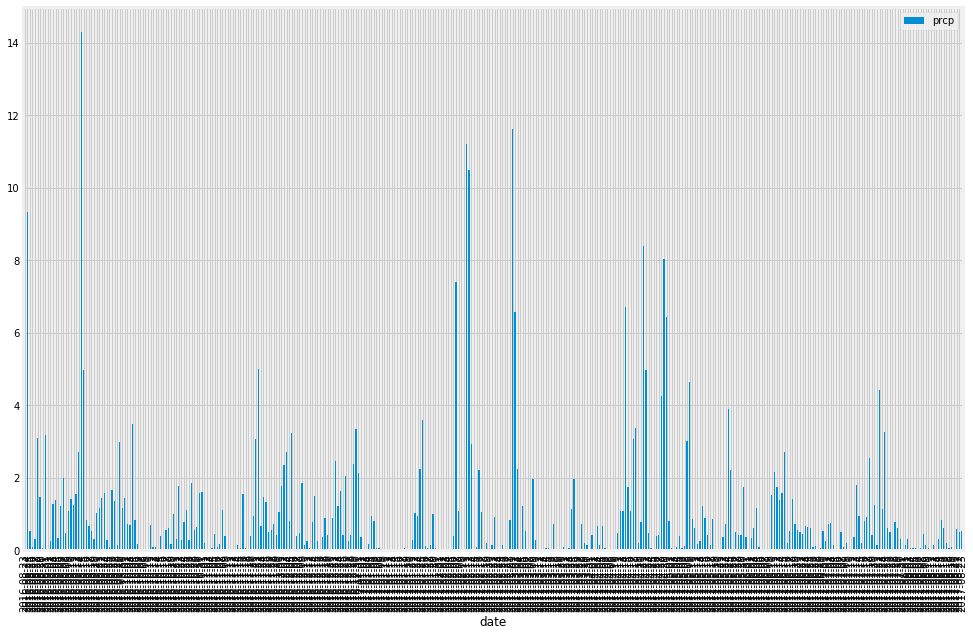

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data

df_plot=df1[["prcp"]]
plot=df_plot.plot(kind="bar", figsize=(15,10))

# Rotate the xticks for the dates
plot.set_xticklabels(df1.index,rotation=90)

plt.show()

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_plot.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [26]:
# How many stations are available in this dataset?
result=session.query(Measurement.date,Measurement.prcp,Measurement.station,Measurement.id,Measurement.tobs).order_by(Measurement.date).all()
df = pd.DataFrame(result)
df["station"].nunique()

9

In [27]:
# What are the most active stations?
# List the stations and the counts in descending order.
df_active=pd.DataFrame(df["station"].value_counts())
df_active

,station
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
df_active=pd.DataFrame(df["station"].value_counts())
df_active=df_active.reset_index(drop=False)

station_id=df_active.iloc[0,0]

station_list=df.loc[df["station"]==station_id,:]
print(f"Lowest Temp for {station_id}: {station_list['tobs'].min()} F")
print(f"Maximum Temp for {station_id}: {station_list['tobs'].max()} F")
print(f"Average Temp for {station_id}: {round(station_list['tobs'].mean(),1)} F")

Lowest Temp for USC00519281: 54.0 F
Maximum Temp for USC00519281: 85.0 F
Average Temp for USC00519281: 71.7 F


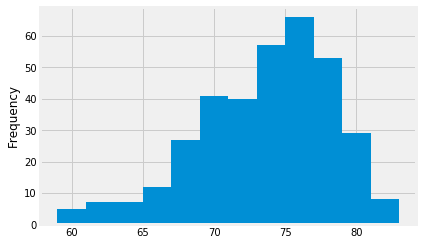

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

result=session.query(Measurement.date,Measurement.prcp,Measurement.station,Measurement.id,Measurement.tobs).filter(Measurement.date>=year_ago).filter(Measurement.station==station_id).order_by(Measurement.date).all()
df2 = pd.DataFrame(result)
df2.head()

ax=df2["tobs"].plot(kind="hist", bins=12)
ax.set_ylabel("Frequency")
plt.show()


In [125]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [126]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
TripTemp=calc_temps('2017-02-28', '2017-03-05')
TripTemp

[(64.0, 72.02777777777777, 78.0)]

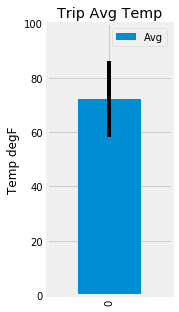

In [127]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
TripTemp_df=pd.DataFrame(pd.Series(TripTemp[0]))
TripTemp_df=TripTemp_df.transpose()
TripTemp_df=TripTemp_df.rename(columns={0:"Min",1:"Avg",2:"Max"})
TripTemp_df["Range"]=TripTemp_df["Max"]-TripTemp_df["Min"]
box1=TripTemp_df.plot(kind="bar", y="Avg", yerr="Range", figsize=(2,5))
box1.set_ylabel("Temp degF")
box1.set_ylim(0,100)
box1.set_xlabel("")
box1.set_title("Trip Avg Temp")
plt.show()

In [128]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

result = engine.execute("select measurement.prcp, station.name, station.latitude, station.longitude, station.elevation, Measurement.date from (measurement join station on measurement.station=station.station)").fetchall()

df = pd.DataFrame(result)
df=df.rename(columns={0:"prcp",1:"name",2:"lat",3:"long",4:"elev",5:"date"})
df=df.loc[(df["date"]>="2017-02-28")&(df["date"]<="2017-03-05"),:].sort_values("prcp",ascending=False)
df

,prcp,name,lat,long,elev,date
8935,2.40,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2017-03-01
5280,2.20,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2017-03-01
14797,2.12,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2017-03-01
19385,2.00,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2017-03-01
14798,1.88,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2017-03-02
12027,1.48,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2017-03-02
5281,1.45,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2017-03-02
2553,1.19,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2017-03-01
7490,1.12,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2017-03-01
2554,0.73,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2017-03-02


## Optional Challenge Assignment

In [129]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [151]:
# calculate the daily normals for your trip

dates=["2017-02-28","2017-03-01","2017-03-02","2017-03-03","2017-03-04","2017-03-05"]

# Stip off the year and save a list of %m-%d strings
for date in dates:
    print(daily_normals(date[-5:])[0])


(65.0, 70.65517241379311, 80.0)
(64.0, 70.0327868852459, 76.0)
(61.0, 70.36666666666666, 78.0)
(60.0, 70.06896551724138, 78.0)
(57.0, 69.27272727272727, 77.0)
(60.0, 67.89090909090909, 76.0)


In [194]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
datelist=[]
for date in dates:
    result=[]
    for x in range(3):
        result.append(daily_normals(date[-5:])[0][x])
    result.append(date)
    datelist.append(result)
    
df=pd.DataFrame(datelist, columns=['min', 'avg','max','date'])
df=df.set_index("date")
df

,min,avg,max
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


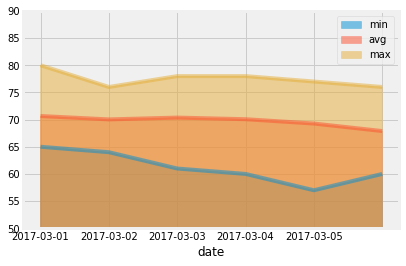

In [202]:
# Plot the daily normals as an area plot with `stacked=False`
plot1=df.plot.area(stacked=False)
plot1.set_xticklabels(df.index)
plot1.set_ylim(50,90)
plt.show()
